In [1]:
import os
import warnings
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches

import seaborn as sns

from fastai.tabular.core import df_shrink
from sklearn.preprocessing import MinMaxScaler

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

### DATA SOURCE: https://data.ibb.gov.tr/en/dataset/hourly-public-transport-data-set

In [2]:
def ingest_data(filename):
    
    # Read data
    raw_df=pd.read_csv("datasets/tr_public_transport_data/raw_data/"+filename, parse_dates=["transition_date"])

    raw_df = (
        raw_df.assign(YEAR=raw_df['transition_date'].dt.year,
                      MONTH=raw_df['transition_date'].dt.month,
                      DAY=raw_df['transition_date'].dt.day,
                      DAYOFWEEK=raw_df['transition_date'].dt.dayofweek)
        .rename(columns={"transition_hour" : "HOUR"})
        .reindex(columns=['transition_date', 'transport_type_id', 'road_type', 'line', 'transfer_type', 'number_of_passage', 
                          'number_of_passenger', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'DAYOFWEEK'])
    )
    
    # Reducing the size of the data by downcasting datatypes
    shrinked_df = df_shrink(raw_df, int2uint=True)

    return shrinked_df


In [3]:
folder_path = "datasets/tr_public_transport_data/raw_data"

all_df = pd.concat(
    (ingest_data(filename=file) for file in tqdm(os.listdir(folder_path))), 
    ignore_index=True
)

  0%|          | 0/40 [00:00<?, ?it/s]

In [4]:
df=all_df.copy()

# Ensuring this column remains category data type.
df['line'] = df['line'].str.strip().astype("category")

In [57]:
df.head()

,transition_date,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger,YEAR,MONTH,DAY,HOUR,DAYOFWEEK
0,2020-01-01,1,HIGHWAY,KIRAC-AVCILAR METROBUS,Normal,76,60,2020,1,1,0,2
1,2020-01-01,1,HIGHWAY,BAKIRKOY-ISTANBUL HAVALIMANI,Normal,20,18,2020,1,1,0,2
2,2020-01-01,1,HIGHWAY,BAHCEKOY-HACIOSMAN METRO,Transfer,7,7,2020,1,1,0,2
3,2020-01-01,1,HIGHWAY,YENIBOSNA (KUYUMCUKENT) - YENIKAPI,Transfer,3,3,2020,1,1,0,2
4,2020-01-01,1,HIGHWAY,KADIKOY-GOLET-SULTANBEYLI,Normal,15,10,2020,1,1,0,2


In [5]:
# merged raw_df space = 1.8+ GB
# merged shrinked_df = 779.6+ MB
# shrinked_df after converting column `line` to category data type = 637.9 MB

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24772562 entries, 0 to 24772561
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   transition_date      datetime64[ns]
 1   transport_type_id    uint8         
 2   road_type            category      
 3   line                 category      
 4   transfer_type        category      
 5   number_of_passage    uint32        
 6   number_of_passenger  uint32        
 7   YEAR                 uint16        
 8   MONTH                uint8         
 9   DAY                  uint8         
 10  HOUR                 uint8         
 11  DAYOFWEEK            uint8         
dtypes: category(3), datetime64[ns](1), uint16(1), uint32(2), uint8(5)
memory usage: 637.9 MB


### This dataset contains over 24 million rows.

In [6]:
# No duplicate rows
# df.duplicated().sum()

In [7]:
df.isnull().sum()

transition_date        0
transport_type_id      0
road_type              0
line                   0
transfer_type          0
number_of_passage      0
number_of_passenger    0
YEAR                   0
MONTH                  0
DAY                    0
HOUR                   0
DAYOFWEEK              0
dtype: int64

In [8]:
# Replacing with english words
df['road_type'] = df['road_type'].map({'OTOYOL':'HIGHWAY', "DENİZ":"SEA", "RAYLI":"RAIL"})
df['road_type'].value_counts()

road_type
HIGHWAY    22948767
SEA         1117927
RAIL         705868
Name: count, dtype: int64

In [9]:
# transport_type_id represents road_type as numbers
df[['transport_type_id', 'road_type']].drop_duplicates(ignore_index=True)

,transport_type_id,road_type
0,1,HIGHWAY
1,3,SEA
2,2,RAIL


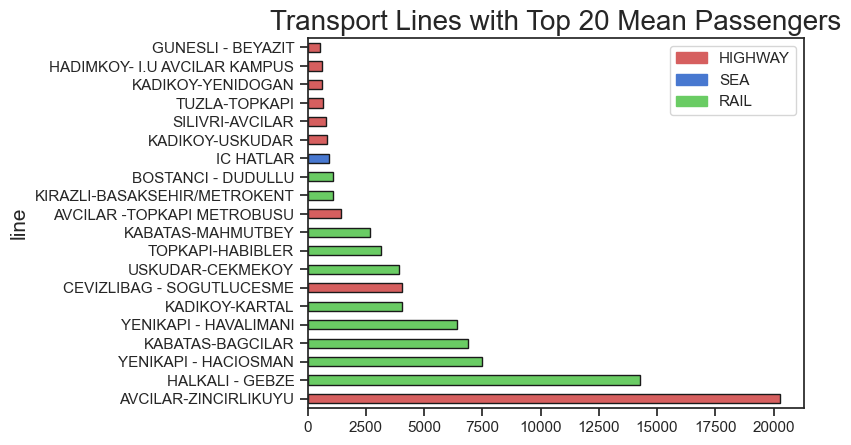

In [10]:
# Top 20 Public Transport Lines
top_20_transport = df.groupby(['line', 'road_type'])['number_of_passenger'].mean().nlargest(20).reset_index()

cmap = {"HIGHWAY" : "r", "SEA" : 'b', "RAIL" : 'g'}

ax = top_20_transport.plot(
    y='number_of_passenger', 
    x='line',
    color=top_20_transport['road_type'].map(cmap),
    kind='barh', 
    edgecolor='k', 
    title=("Transport Lines with Top 20 Mean Passengers")
);

handles = [mpatches.Patch(color=cmap[i]) for i in cmap]
labels = [cat for cat in cmap]
ax.legend(handles, labels);

### The above plot illustrates Transport lines with the top 20 mean passengers. People mostly use Highway and Rail transporation (Bus and metro respectively). Sea travel is probably only used by those who needs to cross between European and Anatolian sodes of Istanbul. 

## **Transfer_type**

##### From the data source website:
##### *It is the field that shows the type of transit passengers using Public Transportation.* 
* **Transfer**: Travel by one or more public transport 
* **Normal**: Journey without transfer 

In [11]:
df['transfer_type'] = df['transfer_type'].replace("Aktarma", "Transfer")
df['transfer_type'].value_counts()

transfer_type
Normal      14160429
Transfer    10612133
Name: count, dtype: int64

# Passenger Travel Patterns

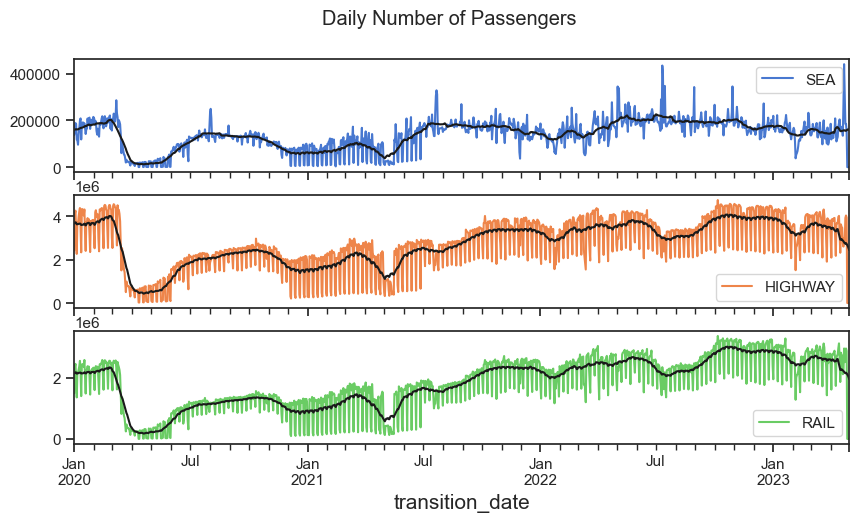

In [58]:
ax = (
    df.groupby(["transition_date", "road_type"])["number_of_passenger"].sum()
    .unstack("road_type")
    .plot(subplots=True, figsize=(10, 5), title=("Daily Number of Passengers"))
)

(
    df.groupby(["transition_date", "road_type"])["number_of_passenger"].sum()
    .unstack("road_type")
    .rolling(30, min_periods=7, center=True).mean()
    .plot(subplots=True, ax=ax, color='k', legend=False)
);

### Similar daily patterns are bserved for all modes of transportation. There is a dip in number of passengers during from March to June 2020 (mostly due to COVID restrictions), followed by a dip on April-May 2021 (due to COVID lockdown).

In [ ]:
# To scale road type values for plotting purposes
scaler = MinMaxScaler()

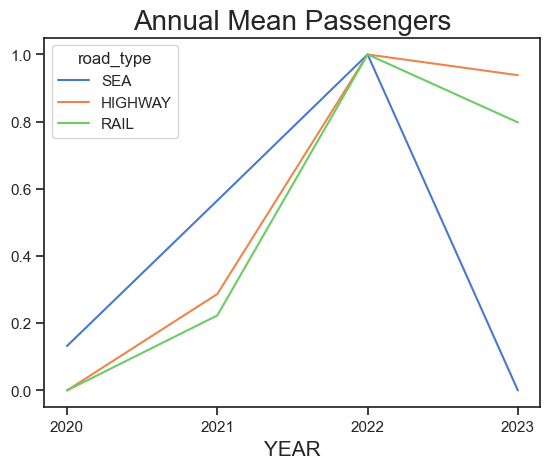

In [59]:
# Annual Patterns
grouped = (
    df.groupby(["YEAR", "road_type"])['number_of_passenger'].mean()
    .unstack("road_type")
)

scaled_df = pd.DataFrame(scaler.fit_transform(grouped), columns=grouped.columns, index=grouped.index)
ax = scaled_df.plot(title="Annual Mean Passengers")
ax.set_xticks([2020, 2021, 2022, 2023]);

### The mean number of passengers for all transporation types is increasing. 
### **Note:** For 2023, data is only available till April. Hence the lower number of passengers in 2023. 

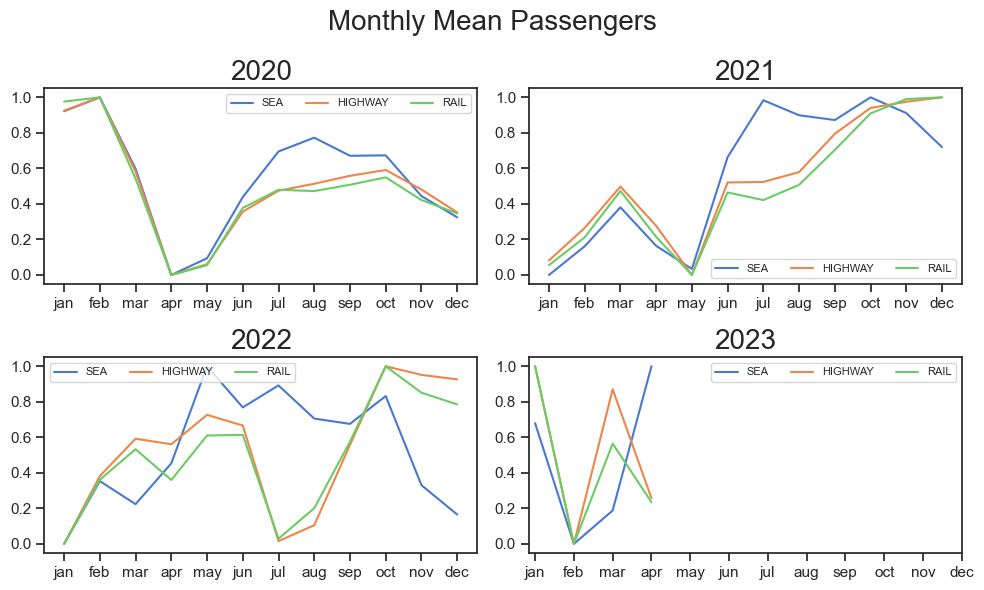

In [61]:
# Monthly Patterns
month_labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, axes = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    grouped = (
        df.query(f"YEAR=={year}")
        .groupby(["MONTH", "road_type"])['number_of_passenger'].mean()
        .unstack("road_type")
    )

    scaled_df = pd.DataFrame(scaler.fit_transform(grouped), columns=grouped.columns, index=grouped.index)
    scaled_df.plot(ax=ax)
    
    ax.set_xlabel("")
    ax.set_xticks(ticks=np.arange(1, 13, 1), labels=month_labels)
    ax.legend(ncol=3, fontsize=8)
    ax.set_title(year)

    plt.suptitle("Monthly Mean Passengers", fontsize=20);

### The monthly pattern of passenger travel across all transportation types were similar in 2020 and 2021. In both these years, the dip in number of passengers is due to COVID measures implemented by the Turkish Government (As explained in the plot earlier).

### However, the pattern differs in 2022. oth RAIL and HIGHWAY sees a dip in number of passeners during July whereas passegers using SEA travel are high.

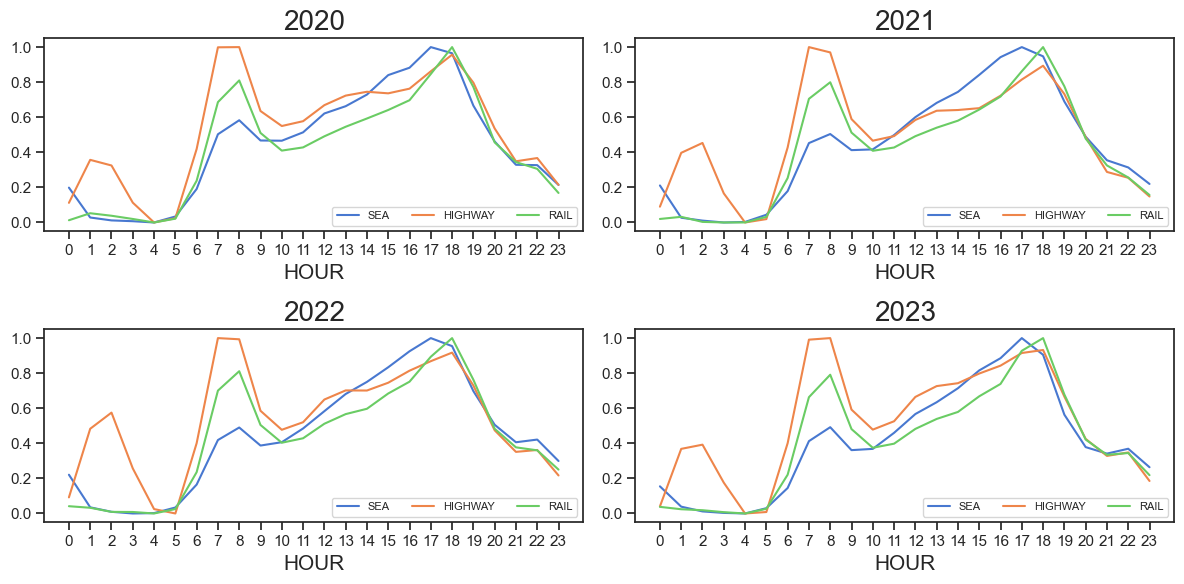

In [62]:
# Hourly Patterns
fig, axes = plt.subplots(2, 2, figsize=(12, 6), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    grouped = (
        df.query(f"YEAR=={year}")
        .groupby(["HOUR", "road_type"])['number_of_passenger'].mean()
        .unstack("road_type")
    )

    scaled_df = pd.DataFrame(scaler.fit_transform(grouped), columns=grouped.columns, index=grouped.index)
    scaled_df.plot(ax=ax)
    
    ax.set_xticks(ticks=np.arange(0, 24, 1))
    ax.legend(ncol=3, fontsize=8)
    ax.set_title(year);

### The above plot depicts hourly patterns in number of passengers for all transportation types. In the early morning (12am to 3am), highway transporation are being used the most. For all transportation types, there are 2 peaks in mean number of passengers. One from 6am to 9am and then from 5pm to 8pm.

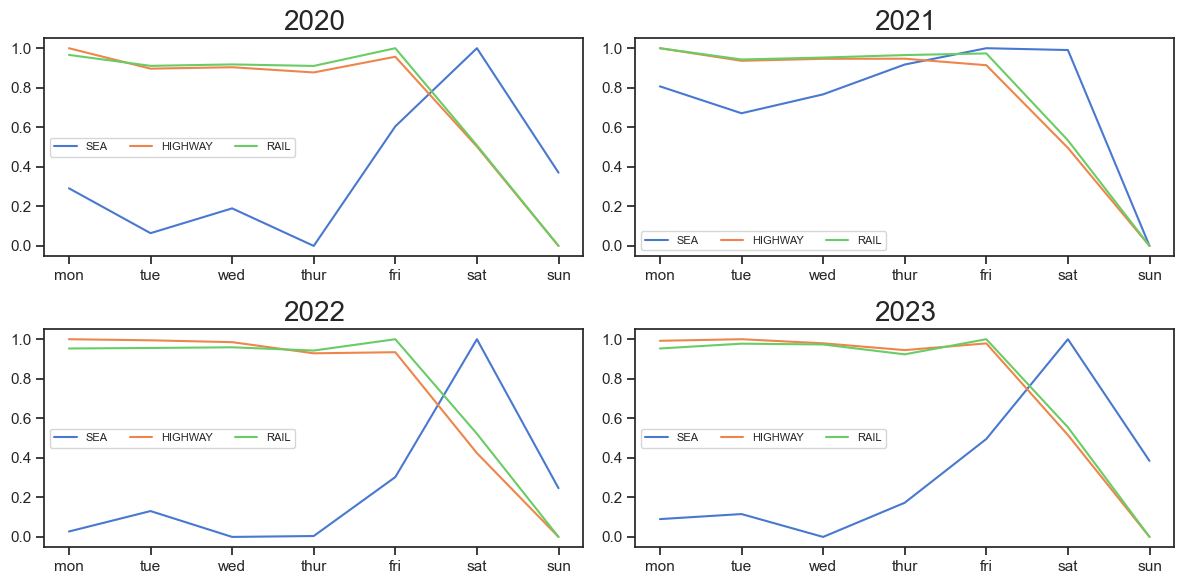

In [51]:
weekday_labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"]

fig, axes = plt.subplots(2, 2, figsize=(12, 6), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    grouped = (
        df.query(f"YEAR=={year}")
        .groupby(["DAYOFWEEK", "road_type"])['number_of_passenger'].mean()
        .unstack("road_type")
    )

    scaled_df = pd.DataFrame(scaler.fit_transform(grouped), columns=grouped.columns, index=grouped.index)
    scaled_df.plot(ax=ax)
    
    ax.set_xlabel("")
    ax.set_xticks(ticks=np.arange(0, 7, 1), labels=weekday_labels)
    ax.legend(ncol=3, fontsize=8)
    ax.set_title(year);

### The above plot illustrates weekly paaterns in number of passengers. Interestingly, passengers travelling by SEA are lowest during weekdays and highest during Saturday, before dipping down again on Sunday. HIGHWAY and RAIL passengers are lower during weekends and higher during weekdays.

In [70]:
df.head()

,transition_date,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger,YEAR,MONTH,DAY,HOUR,DAYOFWEEK
0,2020-01-01,1,HIGHWAY,KIRAC-AVCILAR METROBUS,Normal,76,60,2020,1,1,0,2
1,2020-01-01,1,HIGHWAY,BAKIRKOY-ISTANBUL HAVALIMANI,Normal,20,18,2020,1,1,0,2
2,2020-01-01,1,HIGHWAY,BAHCEKOY-HACIOSMAN METRO,Transfer,7,7,2020,1,1,0,2
3,2020-01-01,1,HIGHWAY,YENIBOSNA (KUYUMCUKENT) - YENIKAPI,Transfer,3,3,2020,1,1,0,2
4,2020-01-01,1,HIGHWAY,KADIKOY-GOLET-SULTANBEYLI,Normal,15,10,2020,1,1,0,2


#### It would be an added benefit if there was a way to incorporate coordinates information to this dataset based on the `line` column. 

In [71]:
df.to_parquet("tr_ist_public_transport_travel.gz", compression="gzip")

In [74]:
# Example of how to reach the parquet file.
# pd.read_parquet("datasets/tr_public_transport_passengers/tr_ist_public_transport_travel.gz")